# Unit test notebook for Fission Fragment 2

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn

%matplotlib inline

In [2]:
mpl.rc(
        "savefig",
        transparent=False,
        bbox="tight",
        pad_inches=0.05,
        dpi=300,
        format="png",
    )

| Potential | Cutoff | Max. order (Max. coefficient) | $\Lambda_{b}$ (MeV) | $m_{\mathrm{eff}}$ (MeV) |
|:---:|:---:|:---:|:---:|:---:|
| SMS | 550 MeV | N$^{4}$LO+ ($c_{6}$) | $560 \pm 10$ | $127 \pm 2$ |
| SMS | 550 MeV | N$^{4}$LO ($c_{5}$) | $\pm$ | $\pm$ |
| SMS | 550 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SMS | 550 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SMS | 500 MeV | N$^{4}$LO+ ($c_{6}$) | $570 \pm 10$ | $138 \pm 3$ |
| SMS | 500 MeV | N$^{4}$LO ($c_{5}$) | $\pm$ | $\pm$ |
| SMS | 500 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SMS | 500 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SMS | 450 MeV | N$^{4}$LO+ ($c_{6}$) | $580 \pm 10$ | $154 \pm 3$ |
| SMS | 450 MeV | N$^{4}$LO ($c_{5}$) | $\pm$ | $\pm$ |
| SMS | 450 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SMS | 450 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SMS | 400 MeV | N$^{4}$LO+ ($c_{6}$) | $610 \pm 10$ | $163 \pm 3$ |
| SMS | 400 MeV | N$^{4}$LO ($c_{5}$) | $\pm$ | $\pm$ |
| SMS | 400 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SMS | 400 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 0.8 fm | N$^{4}$LO ($c_{5}$) | $590 \pm 20$ | $105 \pm 3$ |
| SCS | 0.8 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 0.8 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 0.9 fm | N$^{4}$LO ($c_{5}$) | $720 \pm 20$ | $120. \pm 3$ |
| SCS | 0.9 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 0.9 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 1.0 fm | N$^{4}$LO ($c_{5}$) | $680 \pm 20$ | $122 \pm 3$ |
| SCS | 1.0 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 1.0 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 1.1 fm | N$^{4}$LO ($c_{5}$) | $620 \pm 20$ | $117 \pm 3$ |
| SCS | 1.1 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 1.1 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 1.2 fm | N$^{4}$LO ($c_{5}$) | $570 \pm 20$ | $111 \pm 3$ |
| SCS | 1.2 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 1.2 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 550 MeV | N$^{4}$LO ($c_{5}$) | $530 \pm 20$ | $75 \pm 2$ |
| EMN (Idaho) | 550 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 550 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 500 MeV | N$^{4}$LO ($c_{5}$) | $510 \pm 10$ | $63 \pm 2$ |
| EMN (Idaho) | 500 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 500 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 450 MeV | N$^{4}$LO ($c_{5}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 450 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 450 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GT+ | 0.9 fm | N$^{2}$LO ($c_{3}$) | $560 \pm 30$ | $21 \pm 2$ |
| GT+ | 1.0 fm | N$^{2}$LO ($c_{3}$) | $720 \pm 40$ | $22 \pm 1$ |
| GT+ | 1.1 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GT+ | 1.2 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| Norfolk | (0.8, 0.6) fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| Norfolk | (1.0, 0.7) fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| Norfolk | (1.2, 0.8) fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GO | 500 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GO | 450 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |

In [3]:
from sklearn.linear_model import LinearRegression

# means and standard deviations for N4LO+
Lambdab_sms_n4lop_pts = np.array([560, 570, 580, 610])
Lambdab_sms_n4lop_stddev = np.array([10, 10, 10, 10])
meff_sms_n4lop_pts = np.array([127, 138, 154, 163])
meff_sms_n4lop_stddev = np.array([2, 3, 3, 3])

Lambdab_scs_n4lo_pts = np.array([590, 720, 680, 620, 570])
Lambdab_scs_n4lo_stddev = np.array([20, 20, 20, 20, 20])
meff_scs_n4lo_pts = np.array([105, 120, 122, 117, 111])
meff_scs_n4lo_stddev = np.array([3, 3, 3, 3, 3])

Lambdab_gt_n2lo_pts = np.array([560, 720])
Lambdab_gt_n2lo_stddev = np.array([30, 40])
meff_gt_n2lo_pts = np.array([21, 22])
meff_gt_n2lo_stddev = np.array([2, 1])

Lambdab_emn_n4lo_pts = np.array([530, 510])
Lambdab_emn_n4lo_stddev = np.array([20, 10])
meff_emn_n4lo_pts = np.array([75, 63])
meff_emn_n4lo_stddev = np.array([2, 2])

# Lambdab_norfolk_n2lo_pts = np.array([590, 640])
# Lambdab_norfolk_n2lo_stddev = np.array([10, 10])
# meff_norfolk_n2lo_pts = np.array([138, 179])
# meff_norfolk_n2lo_stddev = np.array([3, 3])

# Lambdab_go_n2lo_pts = np.array([550, 570])
# Lambdab_go_n2lo_stddev = np.array([10, 10])
# meff_go_n2lo_pts = np.array([146, 195])
# meff_go_n2lo_stddev = np.array([3, 3])

# Lambdab_pts = np.concatenate((Lambdab_sms_pts, Lambdab_scs_pts))
# meff_pts = np.concatenate((meff_sms_pts, meff_scs_pts))

<ErrorbarContainer object of 3 artists>

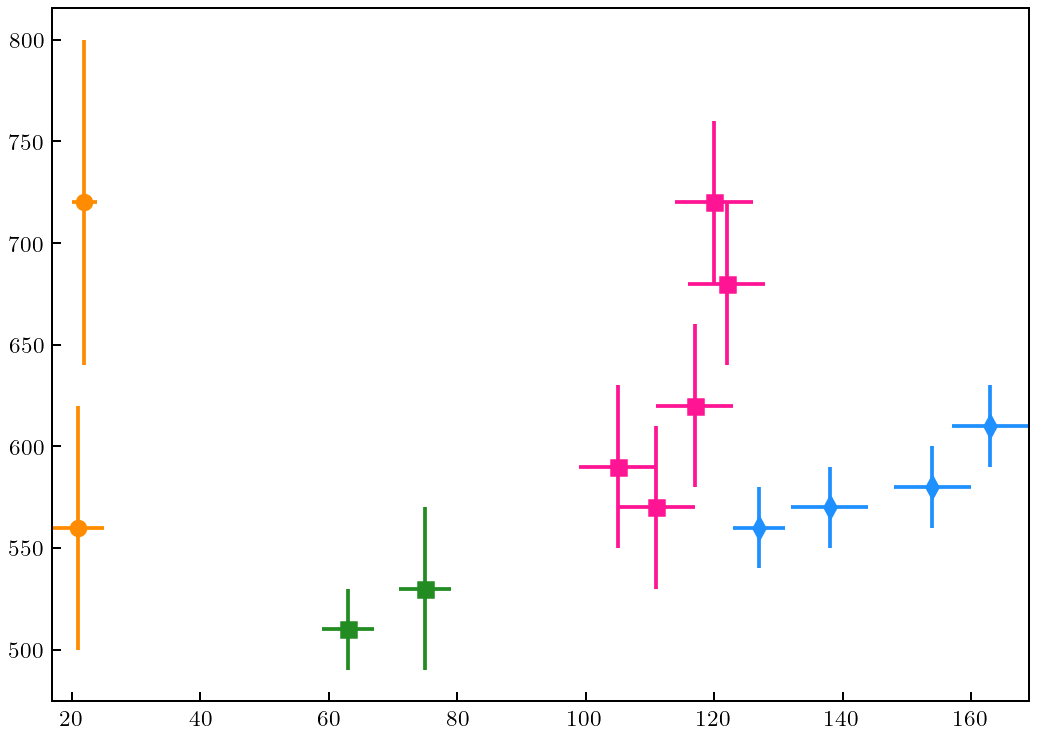

In [4]:
fig_fit, ax_fit = plt.subplots(figsize=(7,5))

# scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
ax_fit.errorbar(meff_sms_n4lop_pts, Lambdab_sms_n4lop_pts, 
                xerr = 2 * meff_sms_n4lop_stddev, yerr = 2 * Lambdab_sms_n4lop_stddev,
                color = 'dodgerblue', label = r'SMS (N$^{4}$LO+)', fmt = 'd')
ax_fit.errorbar(meff_scs_n4lo_pts, Lambdab_scs_n4lo_pts, 
                xerr = 2 * meff_scs_n4lo_stddev, yerr = 2 * Lambdab_scs_n4lo_stddev,
                color = 'deeppink', label = r'SCS (N$^{4}$LO)', fmt = 's')
ax_fit.errorbar(meff_gt_n2lo_pts, Lambdab_gt_n2lo_pts, 
                xerr = 2 * meff_gt_n2lo_stddev, yerr = 2 * Lambdab_gt_n2lo_stddev,
                color = 'darkorange', label = r'GT+ (N$^{2}$LO)', fmt = 'o')
ax_fit.errorbar(meff_emn_n4lo_pts, Lambdab_emn_n4lo_pts, 
                xerr = 2 * meff_emn_n4lo_stddev, yerr = 2 * Lambdab_emn_n4lo_stddev,
                color = 'forestgreen', label = r'EMN (N$^{4}$LO)', fmt = 's')
# ax_fit.errorbar(meff_norfolk_n2lo_pts, Lambdab_norfolk_n2lo_pts, 
#                 xerr = 2 * meff_norfolk_n2lo_stddev, yerr = 2 * Lambdab_norfolk_n2lo_stddev,
#                 color = 'darkviolet', label = r'Norfolk (N$^{2}$LO)', fmt = 'o')
# ax_fit.errorbar(meff_go_n2lo_pts, Lambdab_go_n2lo_pts, 
#                 xerr = 2 * meff_go_n2lo_stddev, yerr = 2 * Lambdab_go_n2lo_stddev,
#                 color = 'gold', label = r'GO (N$^{2}$LO)', fmt = 'o')

SMS (N4LO+): Lambda_b = (1.2 +/- 0.3) m_eff + (398 +/-  51) MeV
SCS (N4LO): Lambda_b = (7.3 +/- 3.0) m_eff + (-206 +/- 348) MeV
GT+ (N2LO): Lambda_b = (160.0 +/- inf) m_eff + (-2800 +/- inf) MeV
EMN (N4LO): Lambda_b = (1.7 +/- inf) m_eff + (405 +/- inf) MeV


C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


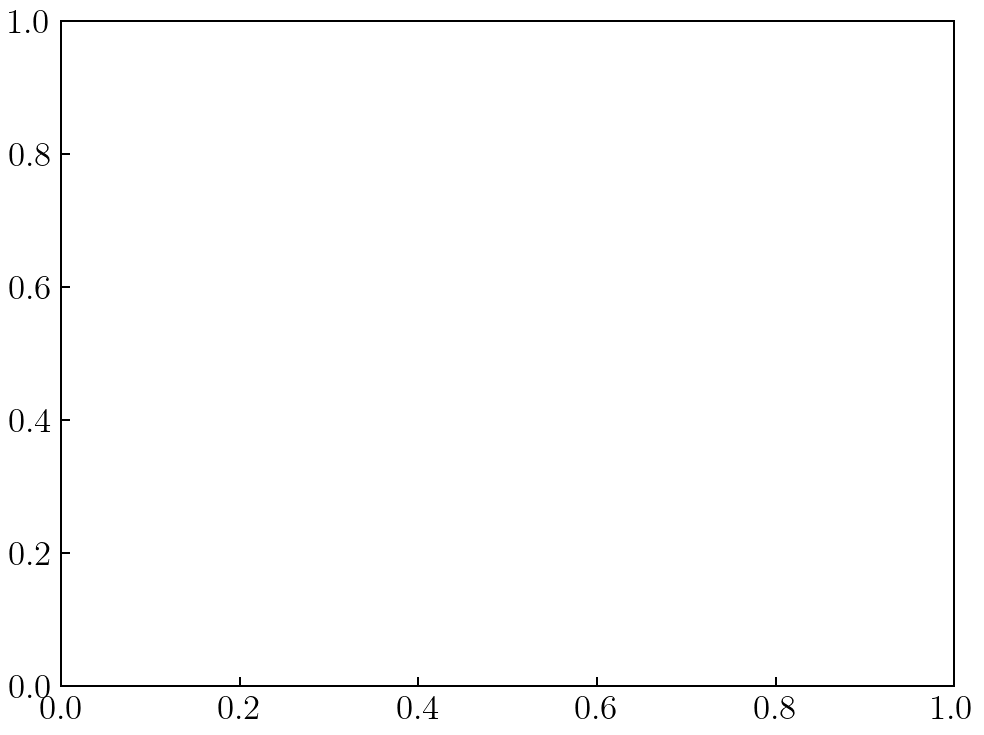

In [5]:
%matplotlib inline

def Lambdab_meff_linear(x, a, b):
    return a * x + b

# fits the points to a line
popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
                                      meff_sms_n4lop_pts, Lambdab_sms_n4lop_pts)
# plots the line of best fit
ax_fit.plot(
    np.linspace(2 * np.min(meff_sms_n4lop_pts) - np.max(meff_sms_n4lop_pts), 
                2 * np.max(meff_sms_n4lop_pts) - np.min(meff_sms_n4lop_pts), 
                100), 
            Lambdab_meff_linear(
                np.linspace(2 * np.min(meff_sms_n4lop_pts) - np.max(meff_sms_n4lop_pts), 
                            2 * np.max(meff_sms_n4lop_pts) - np.min(meff_sms_n4lop_pts), 
                            100), 
                popt[0], popt[1]), 
            color = 'dodgerblue', 
           linestyle = "--", 
           label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
           )
# prints the best fit values
print(f"SMS (N4LO+): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
     f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# fits the points to a line
popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
                                      meff_scs_n4lo_pts, Lambdab_scs_n4lo_pts)
# plots the line of best fit
ax_fit.plot(
    np.linspace(2 * np.min(meff_scs_n4lo_pts) - np.max(meff_scs_n4lo_pts), 
                2 * np.max(meff_scs_n4lo_pts) - np.min(meff_scs_n4lo_pts), 
                100), 
            Lambdab_meff_linear(
                np.linspace(2 * np.min(meff_scs_n4lo_pts) - np.max(meff_scs_n4lo_pts), 
                            2 * np.max(meff_scs_n4lo_pts) - np.min(meff_scs_n4lo_pts), 
                            100), 
                popt[0], popt[1]), 
            color = 'deeppink', 
           linestyle = "--", 
           label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
           )
# prints the best fit values
print(f"SCS (N4LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
     f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# fits the points to a line
popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
                                      meff_gt_n2lo_pts, Lambdab_gt_n2lo_pts)
# plots the line of best fit
ax_fit.plot(
    np.linspace(2 * np.min(meff_gt_n2lo_pts) - np.max(meff_gt_n2lo_pts), 
                2 * np.max(meff_gt_n2lo_pts) - np.min(meff_gt_n2lo_pts), 
                100), 
            Lambdab_meff_linear(
                np.linspace(2 * np.min(meff_gt_n2lo_pts) - np.max(meff_gt_n2lo_pts), 
                            2 * np.max(meff_gt_n2lo_pts) - np.min(meff_gt_n2lo_pts), 
                            100
            ), 
                                popt[0], popt[1]), 
            color = 'darkorange', 
           linestyle = "--", 
           label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$")
# prints the best fit values
print(f"GT+ (N2LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
     f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# fits the points to a line
popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
                                            meff_emn_n4lo_pts, Lambdab_emn_n4lo_pts)
# plots the line of best fit
ax_fit.plot(
    np.linspace(2 * np.min(meff_emn_n4lo_pts) - np.max(meff_emn_n4lo_pts), 
                2 * np.max(meff_emn_n4lo_pts) - np.min(meff_emn_n4lo_pts), 
                100), 
            Lambdab_meff_linear(
                np.linspace(2 * np.min(meff_emn_n4lo_pts) - np.max(meff_emn_n4lo_pts), 
                            2 * np.max(meff_emn_n4lo_pts) - np.min(meff_emn_n4lo_pts), 
                            100), 
                                popt[0], popt[1]), 
            color = 'forestgreen', 
           linestyle = "--")
# prints the best fit values
print(f"EMN (N4LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
     f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, meff_norfolk_pts, Lambdab_norfolk_pts)
# # plots the line of best fit
# ax_fit.plot(np.linspace(100, 200, 100), 
#             Lambdab_meff_linear(np.linspace(100, 200, 100), popt[0], popt[1]), 
#             color = 'darkviolet', 
#            linestyle = "--")
# # prints the best fit values
# print(f"Norfolk: Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, meff_go_pts, Lambdab_go_pts)
# # plots the line of best fit
# ax_fit.plot(np.linspace(100, 200, 100), 
#             Lambdab_meff_linear(np.linspace(100, 200, 100), popt[0], popt[1]), 
#             color = 'gold', 
#            linestyle = "--")
# # prints the best fit values
# print(f"GO: Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

fig_fit.suptitle("All 2D observables", fontsize = 20)
ax_fit.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
# ax_fit.legend(fontsize = 10, 
#               loc = 'upper right', 
#               ncols = 2)
ax_fit.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit.tight_layout()
plt.show()
fig_fit.savefig('figures2/' + 'Lambdab_vs_meff')

## Plots of length scale and variance by order for different potentials

#### Sets meshes and extracts coefficients from the data for a particular observable and potential

In [6]:
# sets the potential of interest
ScaleScheme = EMN500MeV

In [7]:
# choose energy and angle meshes
t_lab = ScaleScheme.get_data("t_lab")

t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
# X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
#                      interaction = "np")[:, None]
# X_train_tlab = E_to_p(E_lab = np.array([1, 12, 33, 65, 108, 161, 225, 300]), 
#                      interaction = "np")[:, None]
X_train_tlab = E_to_p(E_lab = np.array([1, 5, 12, 21, 33, 48, 65, 85, 108, 133, 161, 192, 225, 261, 300, 341]), 
                     interaction = "np")[:, None]
t_lab_label = "Relative momentum (MeV)"
t_lab_name = "prel"
# t_lab_input = t_lab
# X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# t_lab_label = "Lab energy (MeV)"

X_tlab = t_lab_input[:, None]
# t_lab_subset = t_lab_input[0::10]
t_lab_subset = X_train_tlab[:, 0]

degrees = ScaleScheme.get_data("degrees")

# degrees_input = degrees
# X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# degrees_label = "Scattering angle (degrees)"
degrees_input = -np.cos(np.radians(degrees))
# X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
X_train_deg = -np.cos(np.radians(np.array([41, 60, 76, 90, 104, 120, 139])))[:, None]
degrees_label = "Negative cosine"
degrees_name = "cos"

X_deg = degrees_input[:, None]
# degrees_subset = degrees_input[0::10]
degrees_subset = X_train_deg[:, 0]

# extracts data
obs_data_name = "DSG"
obs_data = ScaleScheme.get_data(obs_data_name)

Lambda_b_coeffs = 510
mpi_eff_coeffs = 63

# sets reference scale
if obs_data_name == "DSG":
    yref = obs_data[-1, :, :]
else:
    yref = np.ones(np.shape(obs_data)[1:])

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

# extracts coefficients
coeffs_flattened = gm.coefficients(
            np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
            ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
            ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
            orders=ScaleScheme.orders_full)
coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#### Plots of total cross section for given $\Lambda_{b}$ and $m_{\text{eff}}$

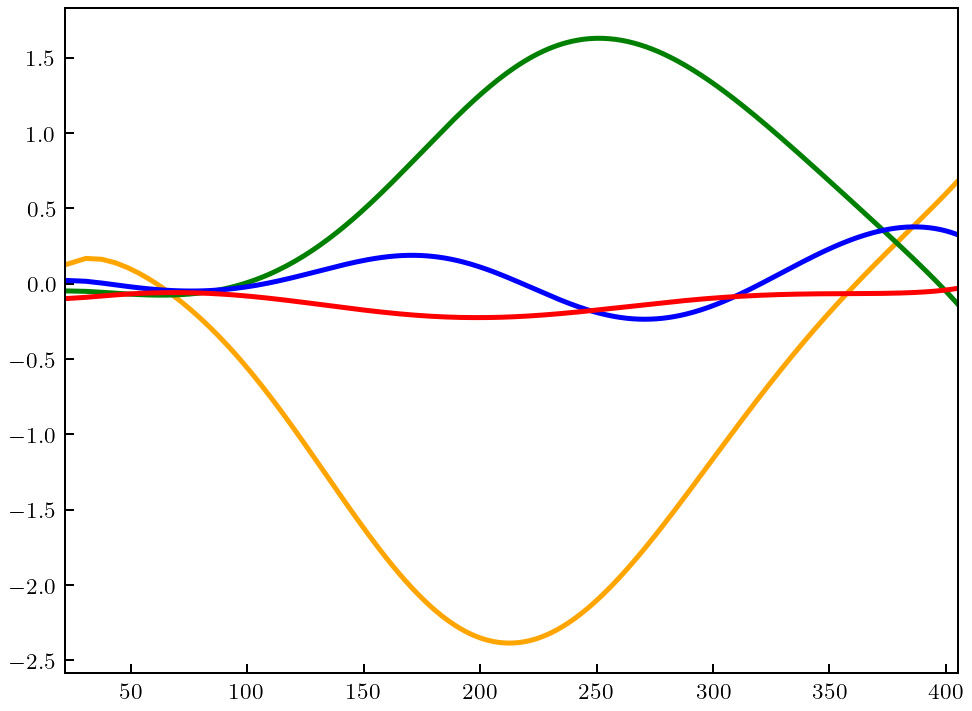

In [8]:
colors_array = ['orange', 'green', 'blue', 'red', 'purple']

fig_sgt, ax_sgt = plt.subplots()

SGT_data = ScaleScheme.get_data("SGT")

p_grid_sgt = p_approx(p_name = "pprel", 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = [0]).T
ratio_sgt = Q_approx(p = p_grid_sgt, 
                 Q_parametrization = 'sum', 
#                  Lambda_b = 725, 
#                  m_pi = 345,
                 Lambda_b = 695, 
                 m_pi = 250,
                 single_expansion=False)

yref_sgt = SGT_data[-1, :]

SGT_coeffs = gm.coefficients(
            SGT_data.T, 
            ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
            ref=np.reshape(yref_sgt, np.shape(yref_sgt)[0]), 
            orders=ScaleScheme.orders_full)
SGT_coeffs = SGT_coeffs.T

# set a limit on x
# print([t > 138 for t in t_lab_input])
t_lab_input_limit = t_lab_input[t_lab_input > 0]

for i, curve in enumerate(SGT_coeffs[1:, :]):
    ax_sgt.plot(t_lab_input_limit, curve[np.isin(t_lab_input, t_lab_input_limit)], 
                color = colors_array[i], linewidth = 2)

#### Plots of scattering-angle length scale and variance by order

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
C:\Users\pjmil\AppData\Local\Temp\ipykernel_26280\1094911782.py:59: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_ls.flat)[o].scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_26280\1094911782.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping

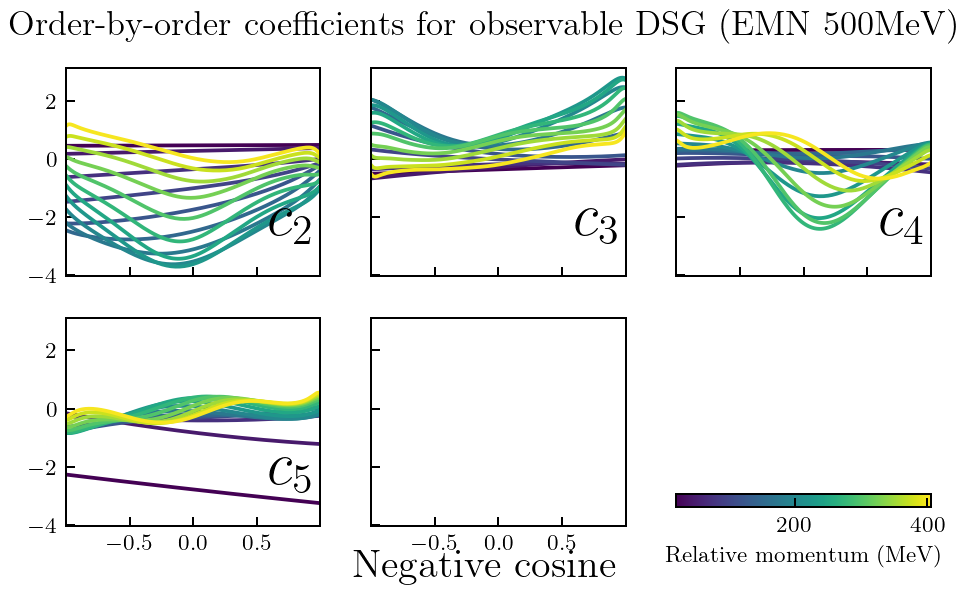

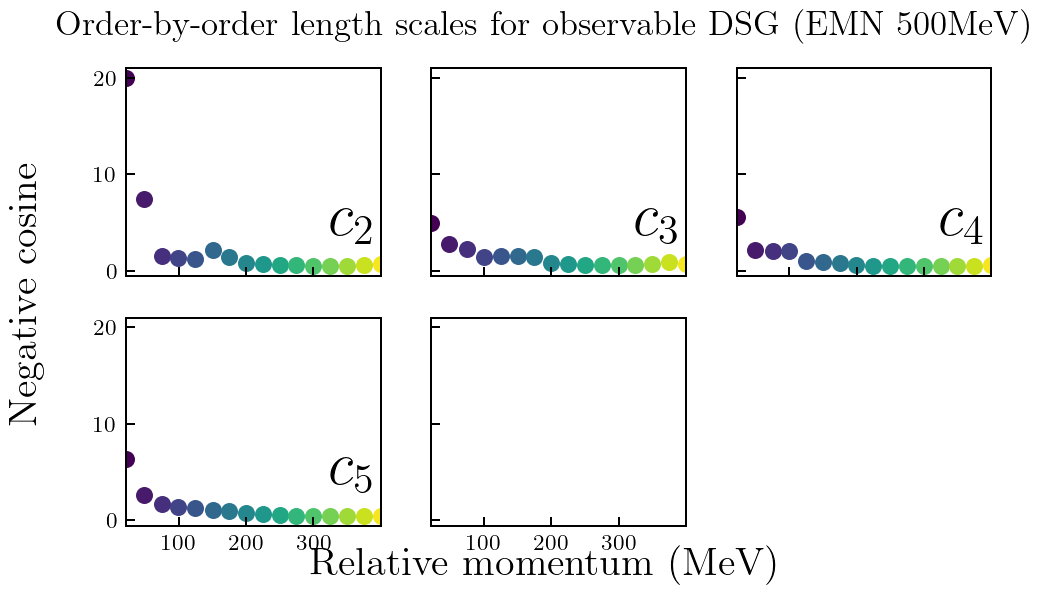

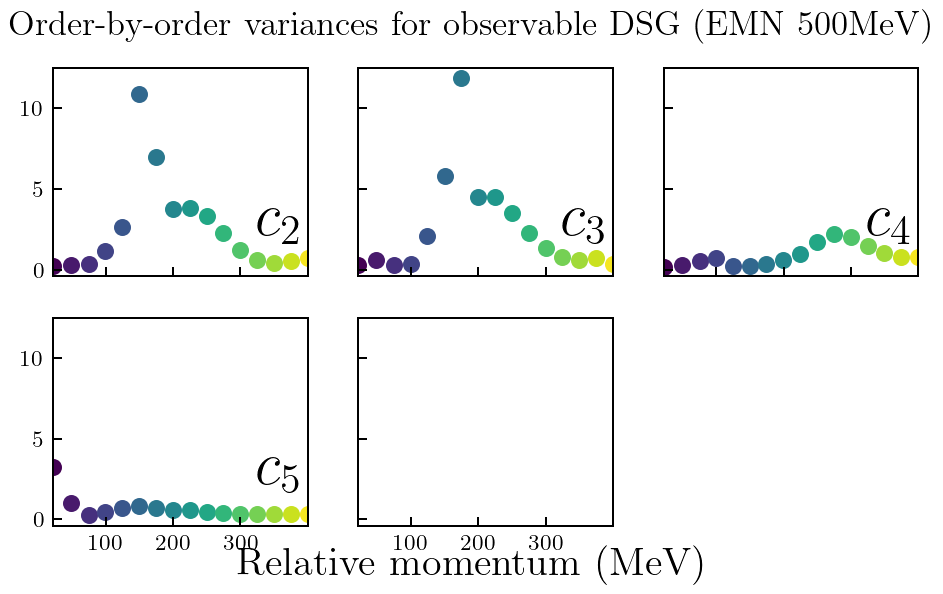

In [9]:
# choose colormap and fix to different energies
cmap_tlab = mpl.cm.viridis
norm_tlab = mpl.colors.Normalize(vmin=np.min(t_lab_input), vmax=np.max(t_lab_input))

# create figure with n_orders subplots
fig_tlab_coeffs, axs_tlab_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_coeffs.supxlabel(degrees_label, size = 16)
fig_tlab_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_ls, axs_tlab_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_ls.supxlabel(t_lab_label, size = 16)
fig_tlab_ls.supylabel(degrees_label, size = 16)
fig_tlab_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_var, axs_tlab_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_var.supxlabel(t_lab_label, size = 16)
fig_tlab_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# plot at each energy in mesh
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    (axs_tlab_coeffs.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_coeffs.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_ls.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_ls.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_var.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_var.flat)[o].transAxes, 
                       size = 24)
        
    for t in t_lab_subset:
        (axs_tlab_coeffs.flat)[o].plot(degrees_input, 
                    coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           10 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'),
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               (coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T)[np.isin(degrees_input, X_train_deg)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_tlab_ls.flat)[o].scatter(t, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_tlab_var.flat)[o].scatter(t, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

fig_tlab_coeffs.delaxes(axs_tlab_coeffs[-1, -1])        
fig_tlab_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab), 
            ax = axs_tlab_coeffs[-1, -1],
             orientation='horizontal', label=t_lab_label)

fig_tlab_ls.delaxes(axs_tlab_ls[-1, -1])
fig_tlab_var.delaxes(axs_tlab_var[-1, -1])

# saves figures
fig_tlab_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_ls.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_var.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of scattering-angle length scale and variance over all orders

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.97112599e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\AppData\Local\Temp\ipykernel_26280\1824043933.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_tlab_ls_all.scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_26280\1824043933.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length match

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.83454586e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 39, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "


[121.0302834  -0.9661962]


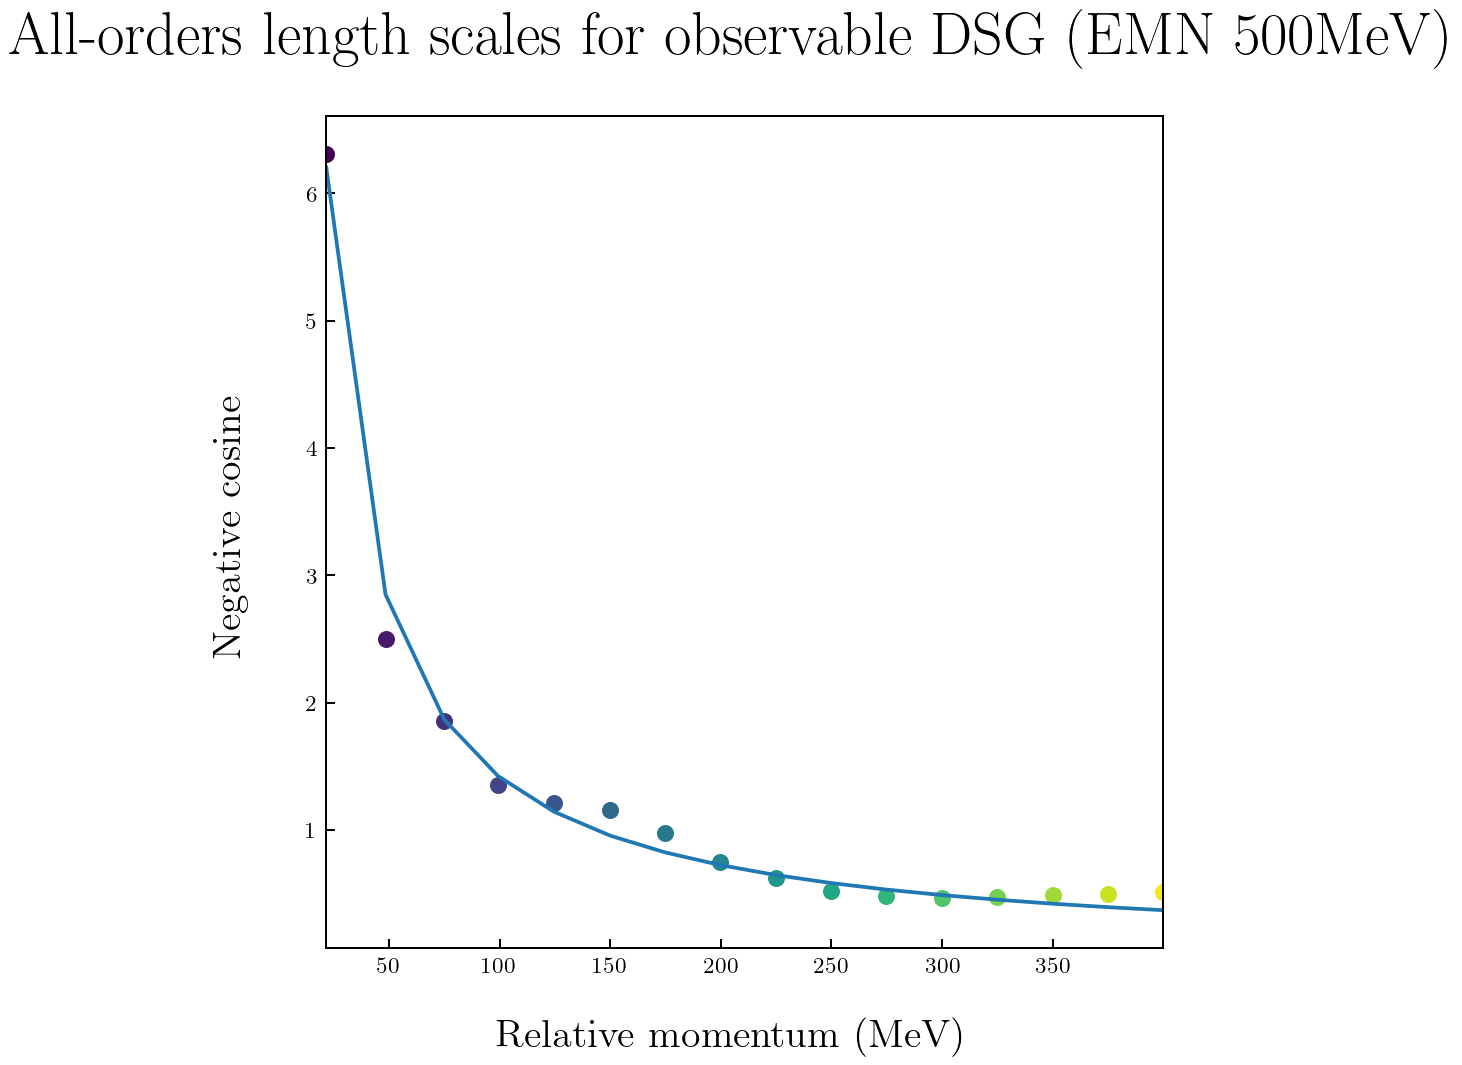

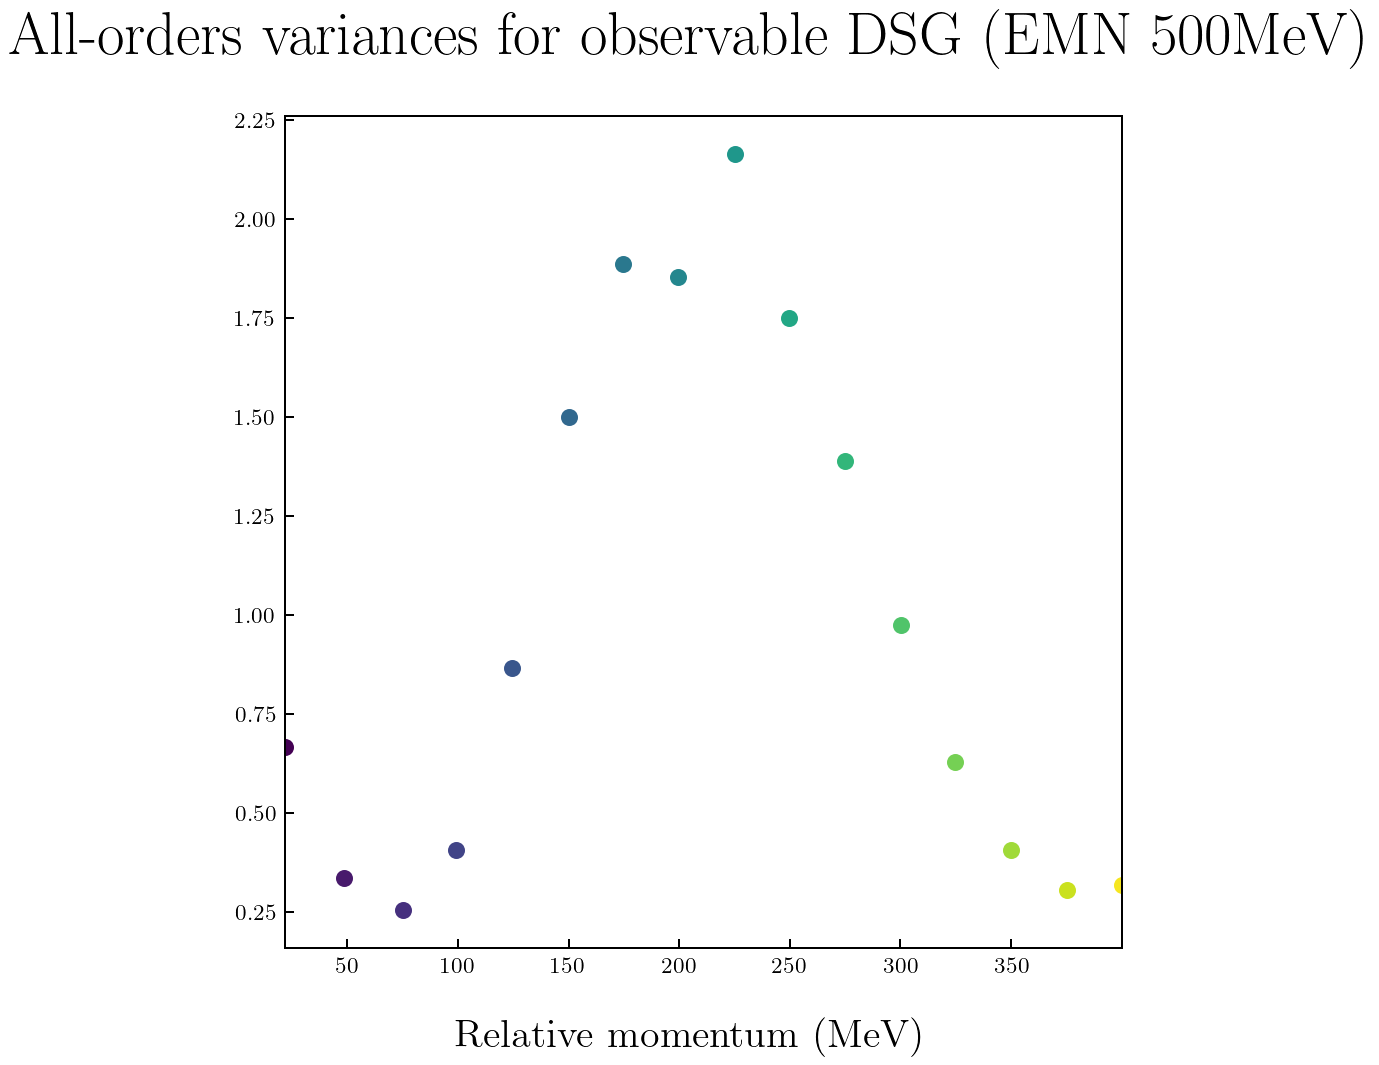

In [10]:
# create figure with n_orders subplots
fig_tlab_ls_all, axs_tlab_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_ls_all.supxlabel(t_lab_label, size = 16)
fig_tlab_ls_all.supylabel(degrees_label, size = 16)
fig_tlab_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_ls_all.semilogx()
# axs_tlab_ls_all.semilogy()

axs_tlab_ls_all_array = np.array([])
axs_tlab_var_all_array = np.array([])

# create figure with n_orders subplots
fig_tlab_var_all, axs_tlab_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_var_all.supxlabel(t_lab_label, size = 16)
fig_tlab_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_var_all.semilogx()
# axs_tlab_var_all.semilogy()

# plots at each energy in mesh
for t in t_lab_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           10 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_deg, 
           np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                      (len(degrees), 
                       np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_tlab_ls_all.scatter(t, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
    axs_tlab_ls_all_array = np.append(axs_tlab_ls_all_array, ls_fit)
    pred, std = gp.predict(X_deg, return_std=True)
    underlying_std = gp.cov_factor_
    axs_tlab_var_all.scatter(t, 
                underlying_std, 
#                 c = 'green')
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
    axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)

# sets fitting function and plots the results
def power(x, a, b):
    return a * x**b
def exponent(x, a, b):
    return a * np.exp(b * x)

popt_power, pcov_power = curve_fit(power, t_lab_subset, axs_tlab_ls_all_array)
print(popt_power)
axs_tlab_ls_all.plot(t_lab_subset, power(t_lab_subset, *popt_power))

# popt_exponent, pcov_exponent = curve_fit(exponent, 
#                                          t_lab_subset, 
#                                          axs_tlab_ls_all_array, 
#                                          p0=(241, -0.00846))
# print(popt_exponent)
# axs_tlab_ls_all.plot(t_lab_subset, exponent(t_lab_subset, *popt_exponent))

# axs_tlab_var_all.axhspan(0, np.min(axs_tlab_var_all_array[4:-2]), alpha=0.2, color='green')
# axs_tlab_var_all.axhspan(np.max(axs_tlab_var_all_array[4:-2]), 4, alpha=0.2, color='green')

# saves figures
fig_tlab_ls_all.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_var_all.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of lab-energy length scale and variance by order

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.96447303e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 41, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.16848236e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 6, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.05078726e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b te

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.11209593e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.08656109e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 34, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.49653356e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 31, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b term

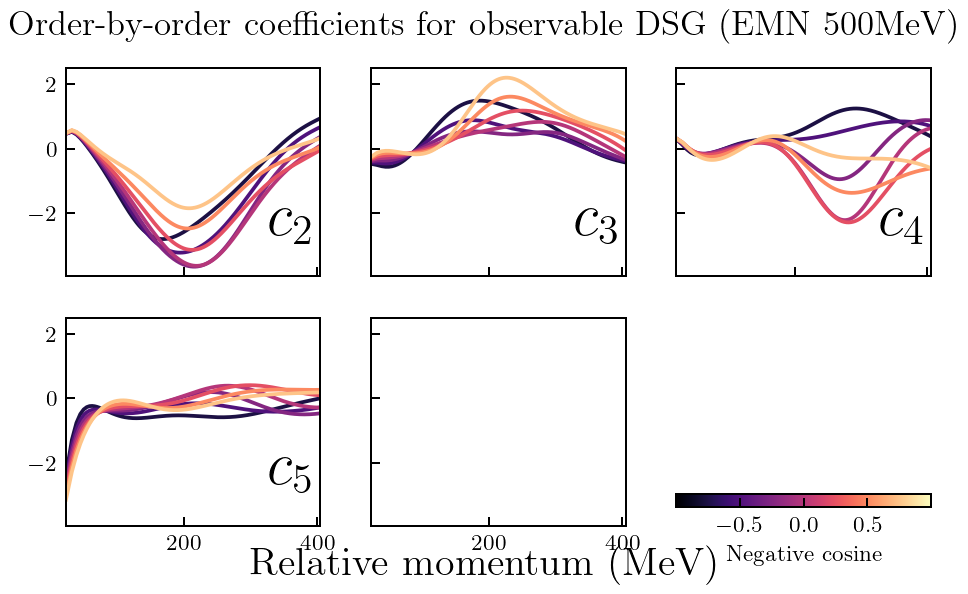

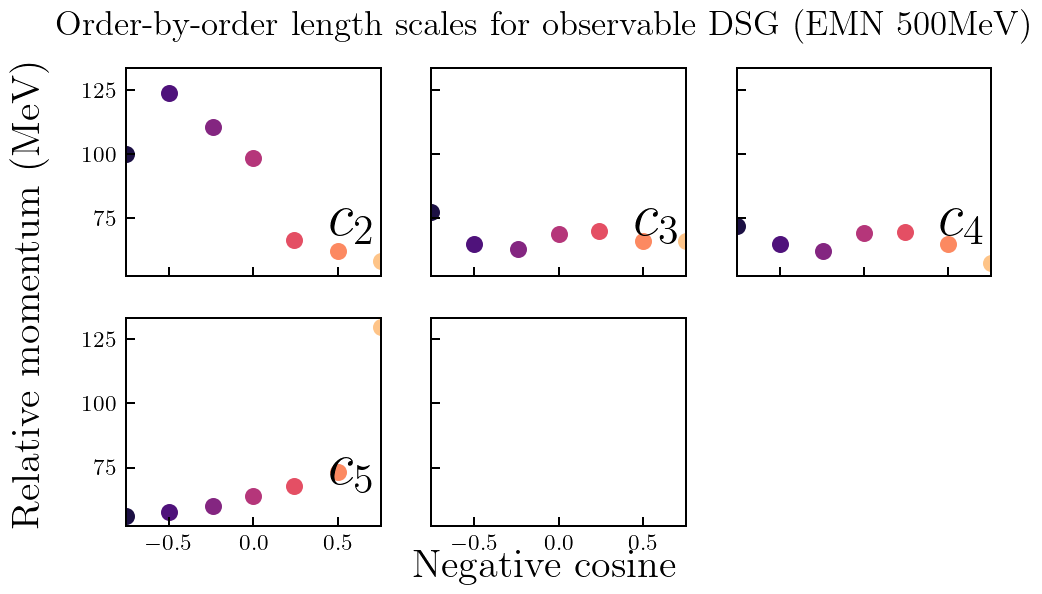

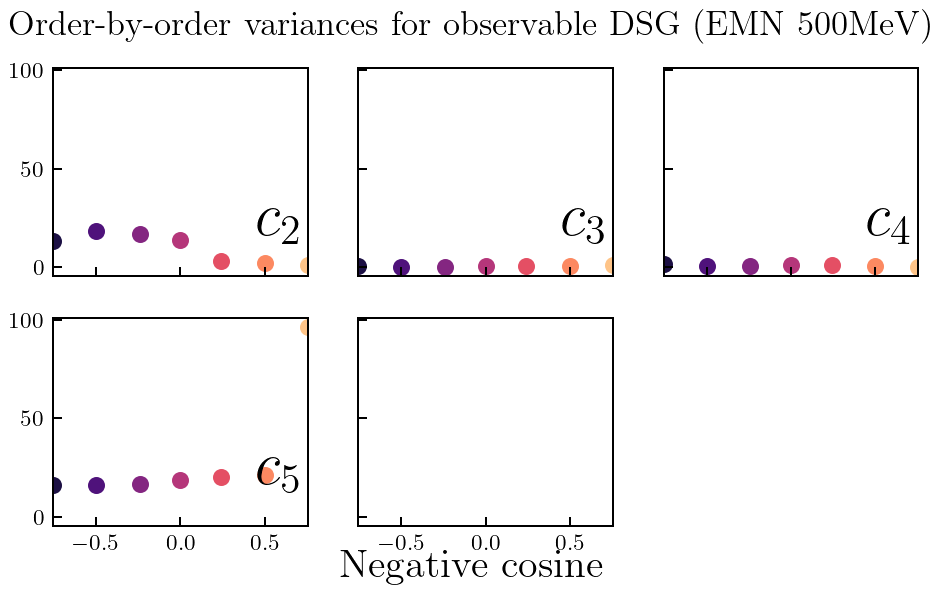

In [11]:
# choose colormap and fix to different energies
cmap_deg = mpl.cm.magma
norm_deg = mpl.colors.Normalize(vmin=np.min(degrees_input), vmax=np.max(degrees_input))

# create figure with n_orders subplots
fig_deg_coeffs, axs_deg_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_coeffs.supxlabel(t_lab_label, size = 16)
fig_deg_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_deg_ls, axs_deg_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_ls.supxlabel(degrees_label, size = 16)
fig_deg_ls.supylabel(t_lab_label, size = 16)
fig_deg_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_deg_var, axs_deg_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_var.supxlabel(degrees_label, size = 16)
fig_deg_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# plots at each angle in mesh
for o in range(1, np.shape(coeffs_surfaces)[0]):
    (axs_deg_coeffs.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_coeffs.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_ls.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_ls.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_var.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_var.flat)[o - 1].transAxes, 
                       size = 24)
        
    for d in degrees_subset:
        (axs_deg_coeffs.flat)[o - 1].plot(t_lab_input, 
                    coeffs_surfaces[o, :, np.isin(degrees_input, d)].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=60,
                      length_scale_bounds=(12, 300)) + \
                      WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_tlab, 
               (coeffs_surfaces[o, :, np.isin(degrees_input, d)].T)[np.isin(t_lab_input, X_train_tlab)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_deg_ls.flat)[o - 1].scatter(d, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        pred, std = gp.predict(X_tlab, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_deg_var.flat)[o - 1].scatter(d, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

fig_deg_coeffs.delaxes(axs_deg_coeffs[-1, -1])        
fig_deg_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg), 
            ax = axs_deg_coeffs[-1, -1],
             orientation='horizontal', label=degrees_label)

fig_deg_ls.delaxes(axs_deg_ls[-1, -1])
fig_deg_var.delaxes(axs_deg_var[-1, -1])

# saves figures
fig_deg_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_ls.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_var.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of lab-energy length scale and variance over all orders

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.24834801e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 32, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\AppData\Local\Temp\ipykernel_26280\4123097312.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_deg_ls_all.scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_26280\4123097312.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matche

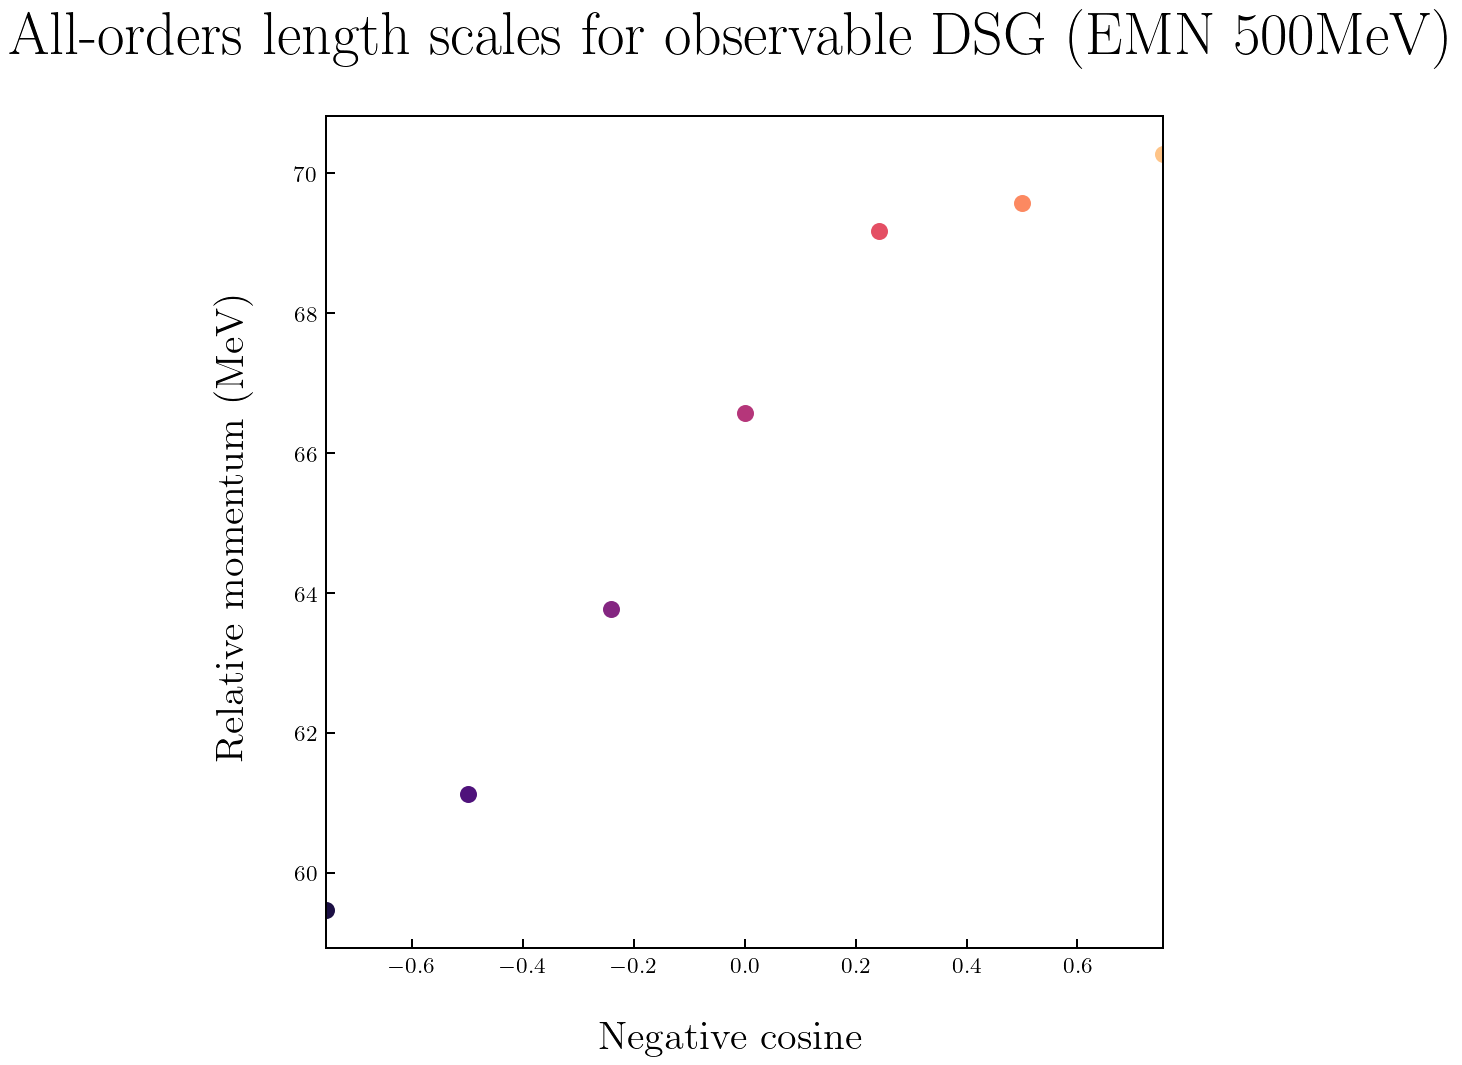

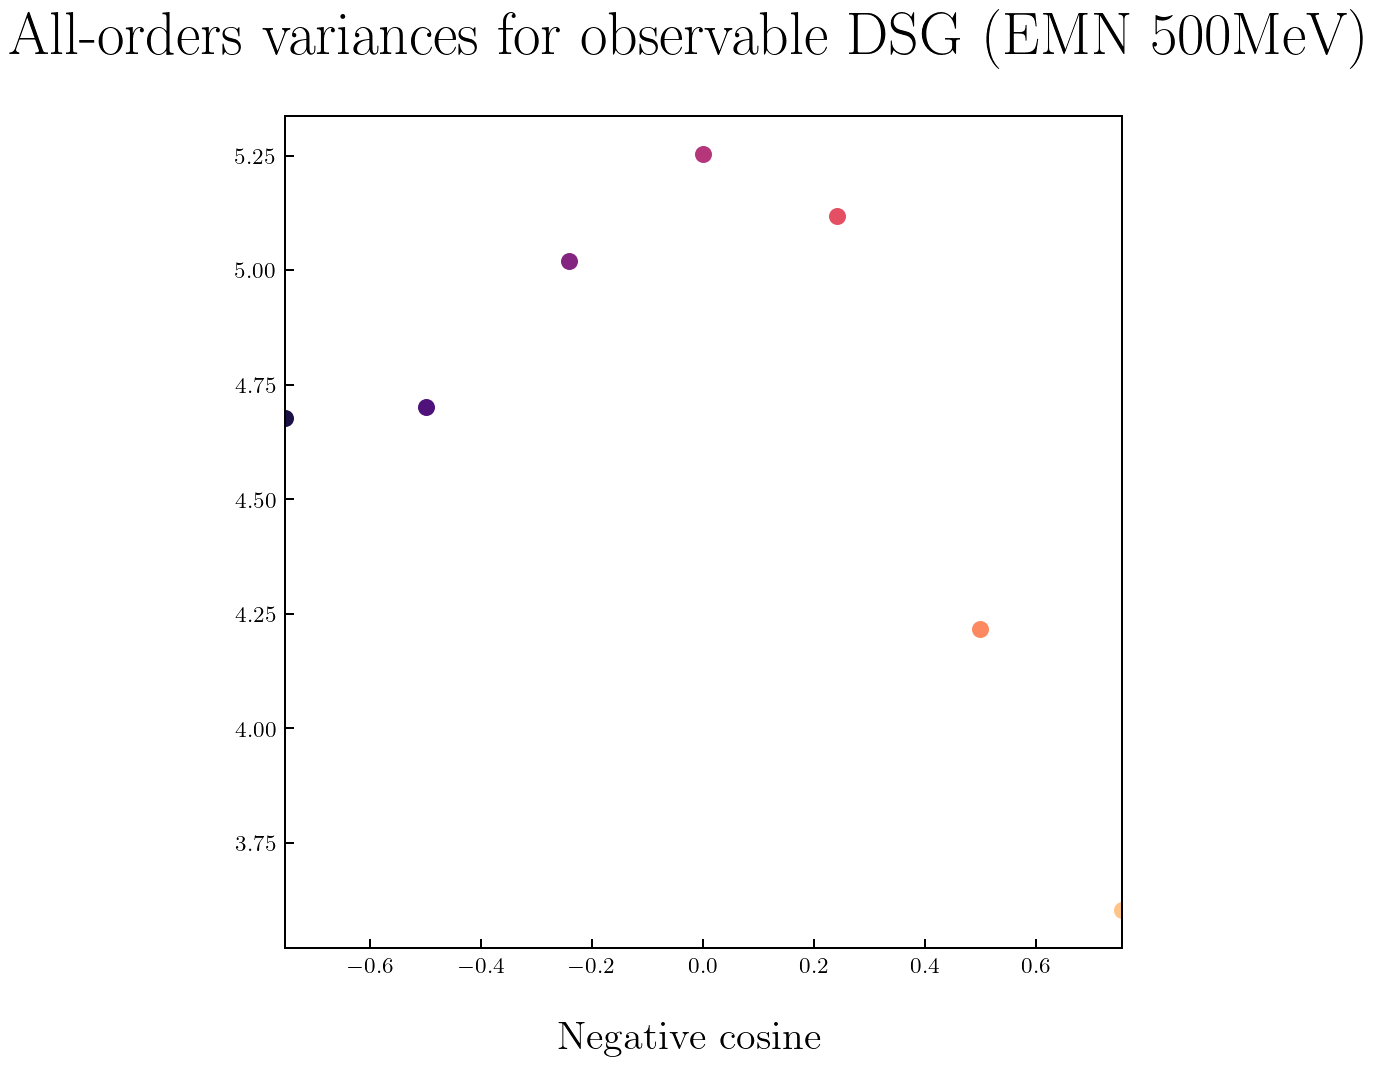

In [12]:
# create figure with n_orders subplots
fig_deg_ls_all, axs_deg_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_ls_all.supxlabel(degrees_label, size = 16)
fig_deg_ls_all.supylabel(t_lab_label, size = 16)
fig_deg_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_ls_all.semilogx()
# axs_deg_ls_all.semilogy()

# create figure with n_orders subplots
fig_deg_var_all, axs_deg_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_var_all.supxlabel(degrees_label, size = 16)
fig_deg_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_var_all.semilogx()
# axs_deg_var_all.semilogy()

# plots at each angle in mesh
for d in degrees_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=60,
                  length_scale_bounds=(12, 300)) + \
                  WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_tlab, 
           np.reshape(coeffs_surfaces[:, :, np.isin(degrees_input, d)].T, 
                     (len(t_lab), 
                     np.shape(coeffs_surfaces)[0]))[np.isin(t_lab_input, X_train_tlab), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_deg_ls_all.scatter(d, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

    pred, std = gp.predict(X_tlab, return_std=True)
    underlying_std = gp.cov_factor_
    axs_deg_var_all.scatter(d, 
                underlying_std, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

# saves figures
fig_deg_ls_all.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_var_all.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)